In [1]:
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget

In [2]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()
    
def make_cmplx_sig(iq_data):
    i = np.array(iq_data[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(iq_data[1:: 2])
    q = q.reshape((len(q), 1))
    print(i[:10])
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten

In [14]:
def read_float_by_unpack_delimeter(file_name, data_type, data_num=0, shift=0, separator='\n'):
    # Load test data
    
    #f = open(file_name,'rb')
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    #print(file_size)
    if data_num == 0:
        if data_type == 'float32':
            data_num = int(file_size / 4)
        if data_type == 'int16':
            data_num = int(file_size / 2)
        if data_type == 'float64':
            data_num = int(file_size / 8)

    if data_type == 'float32':
        t = np.float32
    if data_type == 'int16':
        t = np.int16
    if data_type == 'float64':
        t = np.float64
    
    
    # Open the binary file using a file object
    print("data num")
    print(data_num)
    print(t)
    
    with open(file_name, 'rb') as file:
    # Read the binary data and convert it to a NumPy array
        data = np.fromfile(file, dtype=t, count=data_num, offset=shift, sep=separator)

    #with open(file_name, 'rb') as f:
     #   for line in f.readlines():
            # Each line represents a binary float, strip the newline and unpack
      #      number = struct.unpack('f', line.strip())[0]
       #     data_raw[i] = number
    
    #print("data num ")
    #print(data_num)
    #  102500 is the number of numbers contained in the document, and a floating point number occupies 4 bytes
    #arr = f.read(data_num * 4)
    #data_raw = struct.unpack('f'*data_num, arr)
    
    return data

In [15]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RRC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf
#%%
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [16]:
def save_cmplx_sig(signal, filename, data_type='int16'):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)
    if data_type == 'float64':
        arr_to_type_re = s_re.astype(np.float64)
        arr_to_type_im = s_im.astype(np.float64)
        arr_int = np.empty(len(signal) * 2, dtype=np.float64)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    if data_type == 'float64':
        saved_arr = arr_int.astype(np.float64)
        
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

def downscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * (coeff)

In [19]:
file_path = "qpsk_rrc_float64.bin"
data_type = 'float64'

source_samples = read_float_by_unpack_delimeter(file_path, data_type, 0, 0, '')


data num
2064000
<class 'numpy.float64'>


[[-18709.98389707]
 [ -5993.29299694]
 [  1090.21260212]
 [-15279.836255  ]
 [-17450.33130335]
 [ -1456.37392733]
 [ -6749.42151589]
 [-19530.57842611]
 [ -5517.52801794]
 [  4700.11767293]]


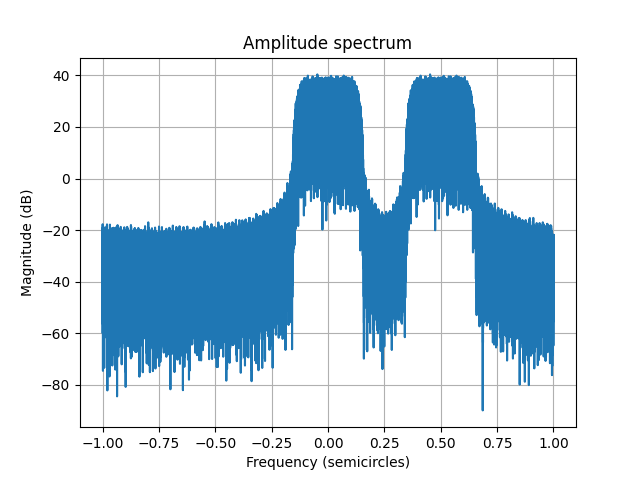

array([[-20.36285198],
       [-30.70123142],
       [-26.94062169],
       ...,
       [-24.29545975],
       [-28.37943918],
       [-25.89399978]])

In [20]:
sig = make_cmplx_sig(source_samples)
plot_spectrum(sig, 0)

In [21]:
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)


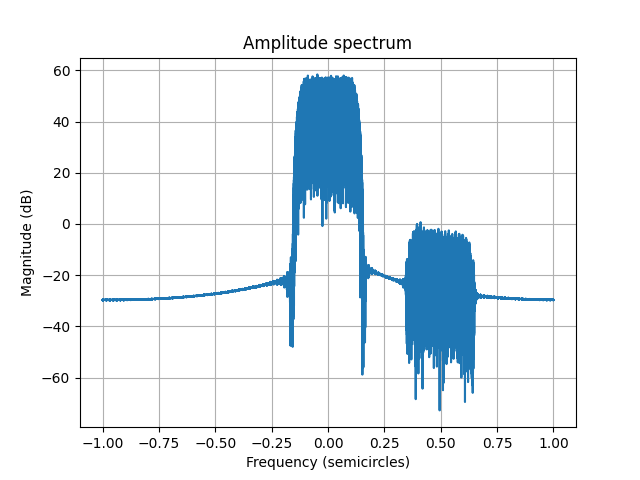

2064000
[-46552.81699027  26659.21923049 -57354.79545345  26421.72184146
 -67101.47342721  22736.36898474 -74812.83539272  15413.30094527
 -79727.24549407   4865.00354986 -81460.12645095  -8280.70917951
 -79644.34842855 -23296.49347815 -73960.70936877 -39030.05220236
 -64569.81798063 -54084.5028863  -51998.58131712 -67334.96789617
 -36789.59743196 -77893.03521438 -19663.91996236 -84962.235385
  -1596.27329951 -88132.13779624  16511.17664658 -87410.48490058
  33820.15990031 -82932.82511223]


In [23]:
sig_rrc = np.convolve(sig, s_rrc, 'same')
plot_spectrum(sig_rrc, 1)
save_cmplx_sig(sig_rrc, "qpsk_rrc_after_py_rrc_fl64.bin", 'float64')

In [10]:
sig_rrc_scaled = downscale_to_i16(sig_rrc)
max(sig_rrc_scaled)

(6.435345763826599e+38-10.006584773260208j)
6.435345763826599e+38
40.82835885644984
5.091723304781065e-35


(32766.999999999996-5.0950760891276345e-34j)

In [11]:
max(sig_rrc)

(6.435345763826599e+38-10.006584773260208j)

In [12]:
sig_rrc[-10:]

array([-4.05271427e+37-0.84186225j, -1.69822097e+37-0.20419843j,
        1.79131075e+37+0.17531066j,  6.19482572e+37+0.07559134j,
        1.11510153e+38-0.3482807j ,  1.61974749e+38-1.16105838j,
        2.08265348e+38-2.14980207j,  2.45500062e+38-3.09714626j,
        2.69634524e+38-3.90634701j,  2.78004405e+38-4.51899695j])